# Hackaton santé

Peut-on établir un lien entre la densité de médecins par spécialité et par territoire et la pratique du dépassement d'honoraires ? 
- Est-ce dans les territoires où la densité est la plus forte que les médecins pratiquent le moins les dépassements d'honoraires ? 
- Est-ce que la densité de certains médecins / praticiens est corrélée à la densité de population pour certaines classes d'âges (bébé/pédiatre, personnes âgées / infirmiers etc...) ?

C'est un sujet issu du [Hackathon "données de santé" de Etalab](https://www.etalab.gouv.fr/retour-sur-le-premier-hackathon-donnees-de-sante) (la page contient des liens vers différents jeux de données utiles, ainsi que d'autres exemples de questions que vous pouvez préférer aborder). Vous pouvez compléter ça avec des données de l'INSEE et des données sur la [démographie des médecins](http://www.data.drees.sante.gouv.fr/ReportFolders/reportFolders.aspx?IF_ActivePath=P,490,497,514).

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression as skLinearRegression 

In [2]:
dataDir = 'data/'

# Relation entre densité de médecin et dépassements d'honoraire

Question à évaluer : Est-ce dans les territoires où la densité est la plus forte que les médecins pratiquent le moins les dépassements d'honoraires ?

## Fichier R

Contient les détails des actes par région.

Fichier R de 2017, source :
- https://www.data.gouv.fr/fr/datasets/depenses-d-assurance-maladie-hors-prestations-hospitalieres-par-caisse-primaire-departement/
- https://www.data.gouv.fr/fr/datasets/r/dc5c050b-ae13-4c02-b12b-c491aad85d63


In [3]:
dfR201701 = pd.read_csv(dataDir + 'r2017/R201701.CSV', 
                        usecols=('dpt', 'region', 'dep_mon'),
                        sep=';', decimal=',', encoding='iso-8859-1')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
dfR201701.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755934 entries, 0 to 3755933
Data columns (total 3 columns):
dpt        object
region     int64
dep_mon    object
dtypes: int64(1), object(2)
memory usage: 86.0+ MB


In [5]:
dfR201701['dep_mon'] = pd.to_numeric(dfR201701['dep_mon'].str.replace('.','').str.replace(',','.'))

In [6]:
dfR201701.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755934 entries, 0 to 3755933
Data columns (total 3 columns):
dpt        object
region     int64
dep_mon    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 86.0+ MB


In [7]:
dfDepassementParDepartement = dfR201701[['dpt','dep_mon']].groupby('dpt').mean()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1dbd6090>]],
      dtype=object)

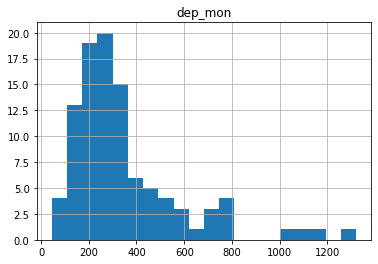

In [21]:
dfDepassementParDepartement.hist(bins=20);

## Statistiques sur les densités de médecins

Disponible déjà analysées sur http://www.data.drees.sante.gouv.fr/TableViewer/tableView.aspx?ReportId=3795

In [9]:
dfMedecin = pd.read_csv(dataDir + 'rpps-medecins18-tab7v3_80437772228084.csv', 
                        usecols=("SPECIALITE", "Ensemble des spécialités d'exercice", "Médecine générale"),
                        header=3, sep=';', encoding='iso-8859-1')

In [10]:
dfMedecin.head()

,SPECIALITE,Ensemble des spécialités d'exercice,Médecine générale
0,ZONE INSCRIPT,NaN,NaN
1,FRANCE ENTIERE,337.0,153.2
2,FRANCE Métropolitaine,339.2,153.7
3,DROM,270.1,139.4
4,Auvergne-Rhône-Alpes,336.8,156.0


In [11]:
dfMedecinDepartements = dfMedecin[dfMedecin['SPECIALITE'].str.contains('^\d+')].copy()

In [12]:
dfMedecinDepartements['dpt'] = dfMedecinDepartements['SPECIALITE'].str.extract('^(\d+)')
dfMedecinDepartements.drop('SPECIALITE', inplace=True, axis=1)

In [13]:
dfConso = dfDepassementParDepartement.merge(dfMedecinDepartements, how='inner', on='dpt')

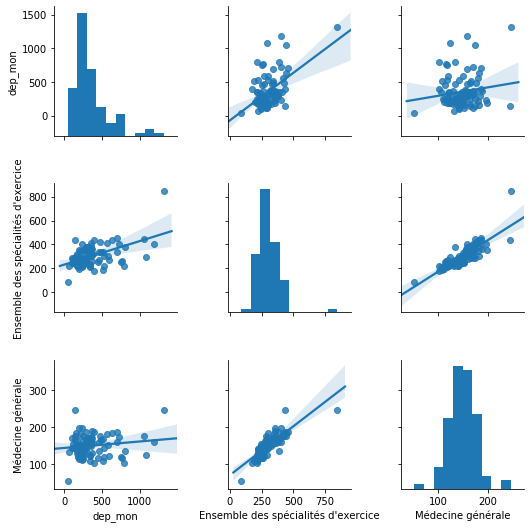

In [15]:
sns.pairplot(dfConso[['dep_mon',"Ensemble des spécialités d'exercice", 'Médecine générale']], kind="reg")

In [16]:
model = skLinearRegression(normalize=False)
model.fit(dfConso[["Ensemble des spécialités d'exercice", 'Médecine générale']], dfConso['dep_mon']);

In [20]:
print("Régression linéaire entre la densité des médecins et les dépassement d'honoraire : \n\tdepassement = %.2f * densité spécialistes %.2f * densité généralistes + %.3f, R^2 = %.3f " \
      % (model.coef_[0], model.coef_[1], model.intercept_, model.score(dfConso[["Ensemble des spécialités d'exercice", 'Médecine générale']], dfConso['dep_mon'])))

Régression linéaire entre la densité des médecins et les dépassement d'honoraire : 
	depassement = 3.58 * densité spécialistes -8.19 * densité généralistes + 496.334, R^2 = 0.560 


### Conclusion

Le dépassement moyen d'honoraires par département est :
- lié à la densité de spécialistes, plus celle-ci est forte, plus les dépassements sont forts
- inversement lié à la densité de généralistes

# Corrélation entre démographie et densité de médecins

Question à évaluer : Est-ce que la densité de certains médecins / praticiens est corrélée à la densité de population pour certaines classes d'âges (bébé/pédiatre, personnes âgées / infirmiers etc...) ?

## Données démographiques

Source : INSEE, estimation de la population au 1er janvier par tranche d'age, sexe et département entre 1975 et 2019. Utilisation des données d'ensemble sur le sexe, pour l'année 2018, pour être en synchro avec les données sur les médecins.  https://www.insee.fr/fr/statistiques/1893198

In [57]:
dfDemo2018 = pd.read_csv(dataDir + 'estim-pop-dep-sexe-aq-2018.csv', header=4, sep=';', thousands=' ')
dfDemo2018.rename(columns={'Unnamed: 0':'dpt'}, inplace=True)
dfDemo2018.drop('Unnamed: 1', inplace=True, axis=1)

In [58]:
dfDemo2018.head()

,dpt,0 à 4 ans,5 à 9 ans,10 à 14 ans,15 à 19 ans,20 à 24 ans,25 à 29 ans,30 à 34 ans,35 à 39 ans,40 à 44 ans,...,55 à 59 ans,60 à 64 ans,65 à 69 ans,70 à 74 ans,75 à 79 ans,80 à 84 ans,85 à 89 ans,90 à 94 ans,95 ans et plus,Total
0,01,38964.0,44765.0,44798.0,39081.0,30392.0,35502.0,40748.0,43421.0,43414.0,...,41606.0,37800.0,35284.0,27338.0,18530.0,15186.0,11090.0,5311.0,1436.0,648744.0
1,02,30542.0,34867.0,35099.0,33001.0,24778.0,28042.0,31054.0,32153.0,32135.0,...,36080.0,35044.0,34487.0,24373.0,16189.0,14758.0,10968.0,5034.0,1202.0,531100.0
2,03,15102.0,17160.0,18578.0,17855.0,13851.0,15247.0,15878.0,17730.0,19006.0,...,23788.0,24556.0,25616.0,20907.0,14614.0,13660.0,10085.0,4651.0,1252.0,335354.0
3,04,7555.0,8713.0,9292.0,8754.0,6060.0,7159.0,8310.0,8769.0,9074.0,...,11952.0,11887.0,12012.0,10062.0,7271.0,5903.0,4174.0,2042.0,672.0,162277.0
4,05,6864.0,8073.0,8321.0,7529.0,5690.0,6738.0,7525.0,8700.0,8349.0,...,10021.0,10081.0,9978.0,7720.0,5436.0,4761.0,3455.0,1622.0,960.0,141602.0


In [69]:
dfDemo2018['Densité bébé'] = dfDemo2018['0 à 4 ans'] / dfDemo2018['Total']
dfDemo2018['Densité > 70'] = (dfDemo2018['70 à 74 ans']+dfDemo2018['75 à 79 ans']+dfDemo2018['80 à 84 ans']+dfDemo2018['85 à 89 ans']+dfDemo2018['90 à 94 ans']+dfDemo2018['95 ans et plus']) / dfDemo2018['Total']

### Données des densités de médecins

Disponible déjà analysées pour 2018 sur http://www.data.drees.sante.gouv.fr/TableViewer/tableView.aspx?ReportId=3795


In [91]:
dfMedecin2 = pd.read_csv(dataDir + 'rpps-medecins18-tab7v3_80437772228084.csv', 
                        usecols=("SPECIALITE", 'Pédiatrie', "Gynécologie médicale", "Gynécologie-obstétrique",
                                 "Gériatrie", "Chirurgie urologique", "Rhumatologie"),
                        header=3, sep=';', encoding='iso-8859-1')

In [92]:
dfMedecinDepartements2 = dfMedecin2[dfMedecin['SPECIALITE'].str.contains('^\d+')].copy()
dfMedecinDepartements2['dpt'] = dfMedecinDepartements2['SPECIALITE'].str.extract('^(\d+)')
dfMedecinDepartements2.drop('SPECIALITE', inplace=True, axis=1)

#### Consolidation des données en 1 dataframe

In [94]:
dfConso2 = dfDemo2018.merge(dfMedecinDepartements2, on='dpt')

## Corrélation bébé / pédiatre

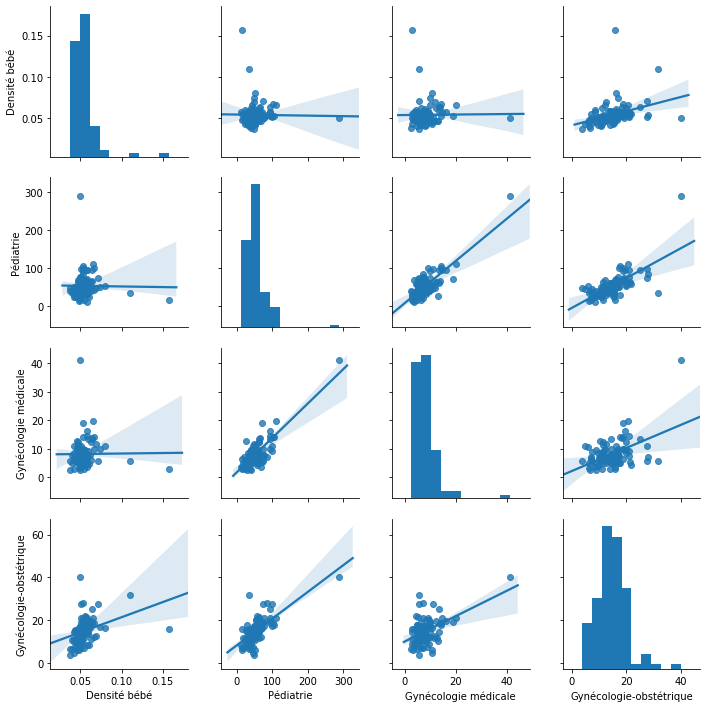

In [95]:
sns.pairplot(dfConso2[['Densité bébé','Pédiatrie', "Gynécologie médicale", "Gynécologie-obstétrique"]], kind="reg")

Graphiquement, la plus forte corrélation est entre la densité de bébés et la densité de médecins gynécologues obstétriques.

A noter: présence de points singuliers sur la densité de bébés avec des densités très fortes

In [100]:
model2 = skLinearRegression(normalize=False)
model2.fit(dfConso2[['Pédiatrie', "Gynécologie médicale", "Gynécologie-obstétrique"]], dfConso2["Densité bébé"]);
r2_2 = model2.score(dfConso2[['Pédiatrie', "Gynécologie médicale", "Gynécologie-obstétrique"]], dfConso2["Densité bébé"])
print("Régression linéaire des densités: bébé = %.3e pédiatre + %.3e gynéco med + %.3e gynéco obst + %.3e, R^2 = %.3f" \
     % (model2.coef_[0], model2.coef_[1], model2.coef_[2], model2.intercept_, r2_2))

Régression linéaire des densités: bébé = -3.274e-04 pédiatre + 7.567e-04 gynéco med + 1.829e-03 gynéco obst + 3.837e-02, R^2 = 0.273


Numériquement, la corrélation entre les densités de bébés et de gynéco (médicaux et obstétrique) est confirmée. Etonament les densités de bébés et pédiatres sont inversement liées.

#### Retrait des points singuliers sur les densités de bébés

In [98]:
dfConso2_2 = dfConso2[dfConso2['Densité bébé'] <= 0.1]
model2_2 = skLinearRegression(normalize=False)
model2_2.fit(dfConso2_2[['Pédiatrie', "Gynécologie médicale", "Gynécologie-obstétrique"]], dfConso2_2["Densité bébé"]);

r2_2_2 = model2_2.score(dfConso2_2[['Pédiatrie', "Gynécologie médicale", "Gynécologie-obstétrique"]], dfConso2_2["Densité bébé"])
print("Régression linéaire des densités: bébé = %.3e pédiatre + %.3e gynéco med + %.3e gynéco obst + %.3e, R^2 = %.3f" \
     % (model2_2.coef_[0], model2_2.coef_[1], model2_2.coef_[2], model2_2.intercept_, r2_2_2))

Régression linéaire des densités: bébé = -1.659e-04 pédiatre + 6.231e-04 gynéco med + 1.023e-03 gynéco obst + 4.133e-02, R^2 = 0.263


Les corrélations restent faibles

## Corrélation personnes agées et spécialités

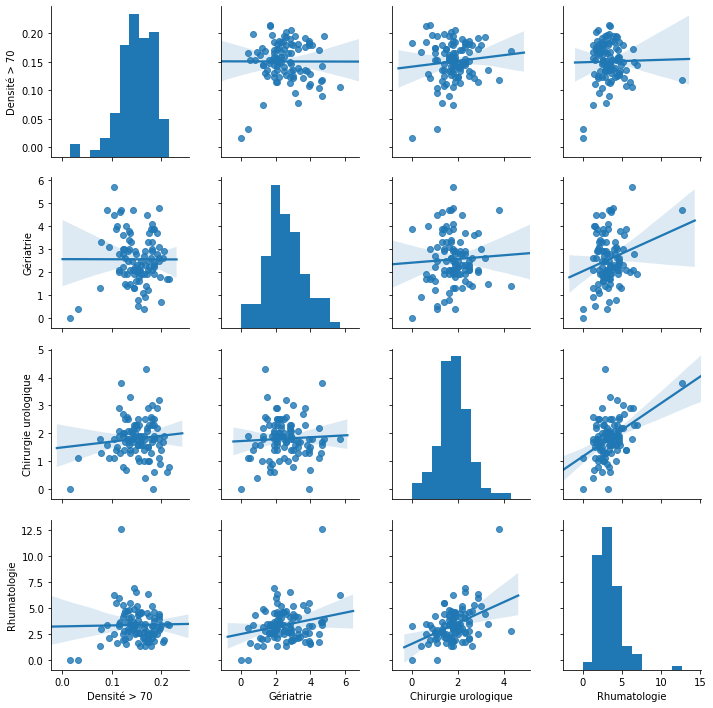

In [101]:
sns.pairplot(dfConso2[['Densité > 70', "Gériatrie", "Chirurgie urologique", "Rhumatologie"]], kind="reg");

In [102]:
model3 = skLinearRegression(normalize=False)
model3.fit(dfConso2[["Gériatrie", "Chirurgie urologique", "Rhumatologie"]], dfConso2["Densité > 70"]);
r3 = model3.score(dfConso2[["Gériatrie", "Chirurgie urologique", "Rhumatologie"]], dfConso2["Densité > 70"])
print("Régression linéaire des densité: senior (> 70 ans) = %.3e gériatres + %.3e chir urologues + %.3e rhumatologues + %.3e, R^2 = %.3f" \
     % (model3.coef_[0], model3.coef_[1], model3.coef_[2], model3.intercept_, r3))

Régression linéaire des densité: senior (> 70 ans) = -2.330e-05 gériatres + 5.735e-03 chir urologues + -6.637e-04 rhumatologues + 1.426e-01, R^2 = 0.011


Corrélations très très faibles entre les spécialistes et la densité de personnes agées.